In [1]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd 
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
import zipfile
import os

# Path to your zip file and where you want to extract
zip_file_path = 'archive (4).zip'  # Replace with your file path
extract_path = 'dataset/'  # Folder where you want to extract the files

# Ensure the extraction path exists
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

Dataset extracted to dataset/


['Bhujasana', 'Padamasana', 'Tadasana', 'Trikasana', 'Vrikshasana']


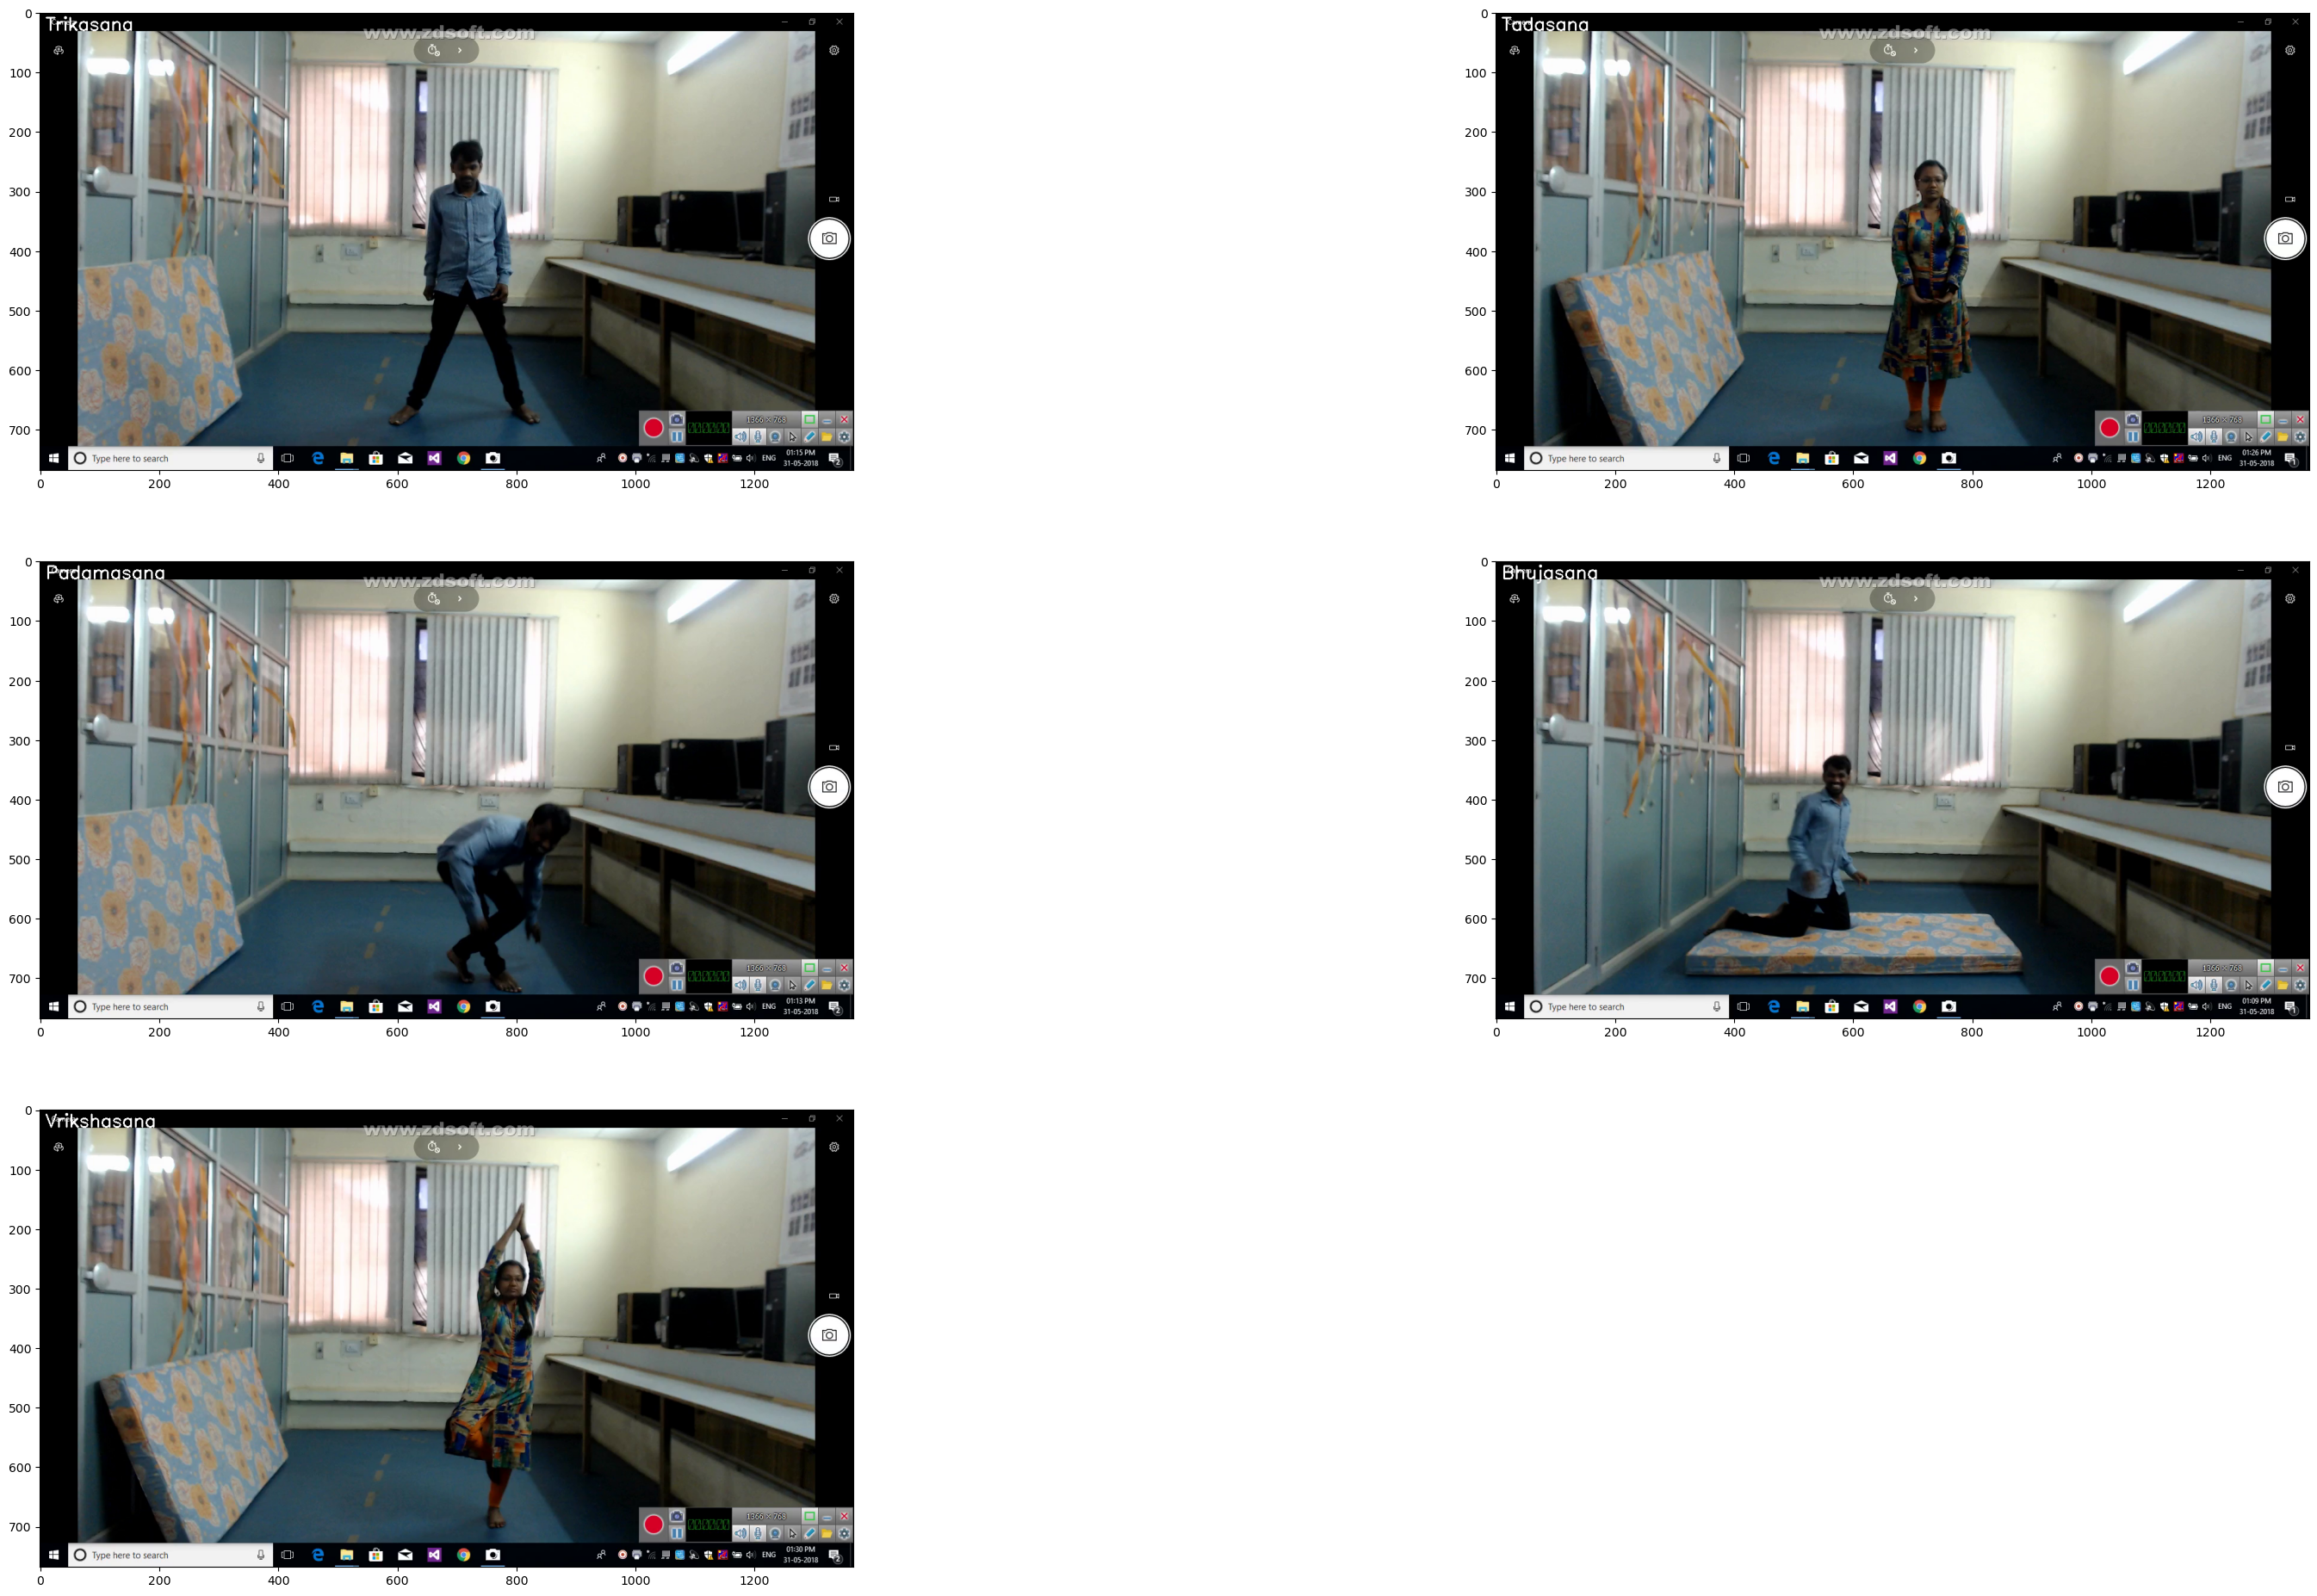

In [3]:
plt.figure(figsize = (40, 40))
 
# Get the names of all classes/categories in dataset.
all_classes_names = os.listdir('dataset/dataset/test')
print(all_classes_names)
 

random_range = random.sample(range(len(all_classes_names)), 5)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'dataset/dataset/test/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'dataset/dataset/test/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 2, counter);plt.imshow(rgb_frame);plt.axis('on')


In [12]:
TRAIN_DIR = 'dataset/dataset/train'  # Path to the training data
TEST_DIR = 'dataset/dataset/test'  # Path to the testing data
FRAME_SAVE_DIR = 'frames'  # Path where extracted frames will be saved
CLASSES_LIST = ['Padamasana', 'Tadasana', 'Vrikshasana', 'Trikasana', 'Bhujasana']
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128  # Example image resolution
SEQUENCE_LENGTH = 30  # Number of frames to extract per video


In [13]:
def create_class_directories(data_type):
    '''
    Creates directories for storing extracted frames, separated into class folders.
    Args:
        data_type: 'train' or 'test', indicating whether to create train or test directories.
    '''
    base_dir = os.path.join(FRAME_SAVE_DIR, data_type)
    for class_name in CLASSES_LIST:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)


In [14]:
def extract_frames_and_save(video_path, save_dir, class_name):
    '''
    Extract frames from a video, save them as images, and return the pixel values.
    Args:
        video_path: The path of the video file.
        save_dir: The directory where the extracted frames will be saved.
        class_name: The class label associated with the video.
    Returns:
        frames_list: A list containing the pixel values of the resized frames.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

        # Save the frame as an image
        frame_filename = os.path.join(save_dir, class_name, f"{os.path.basename(video_path).split('.')[0]}_frame{frame_counter}.jpg")
        cv2.imwrite(frame_filename, resized_frame)

    video_reader.release()
    return frames_list


In [15]:
def create_dataset(data_dir, data_type):
    '''
    Creates a dataset by extracting frames from videos and storing them as images.
    Args:
        data_dir: The directory containing the video data (either train or test).
        data_type: 'train' or 'test', indicating the dataset type.
    Returns:
        features: A list containing the pixel values of the frames.
        labels: A list containing the corresponding class indexes.
    '''
    features = []
    labels = []

    # Iterate through the class list and extract video frames
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data for Class: {class_name} ({data_type})')
        
        class_dir = os.path.join(data_dir, class_name)
        video_files = os.listdir(class_dir)

        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)
            frames = extract_frames_and_save(video_path, os.path.join(FRAME_SAVE_DIR, data_type), class_name)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)

    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels


In [16]:
# Create directories for train and test frame saving
create_class_directories(data_type='train')
create_class_directories(data_type='test')

In [17]:
# Create train dataset
features_train, labels_train = create_dataset(TRAIN_DIR, data_type='train')

# Create test dataset
features_test, labels_test = create_dataset(TEST_DIR, data_type='test')

Extracting Data for Class: Padamasana (train)
Extracting Data for Class: Tadasana (train)
Extracting Data for Class: Vrikshasana (train)
Extracting Data for Class: Trikasana (train)
Extracting Data for Class: Bhujasana (train)
Extracting Data for Class: Padamasana (test)
Extracting Data for Class: Tadasana (test)
Extracting Data for Class: Vrikshasana (test)
Extracting Data for Class: Trikasana (test)
Extracting Data for Class: Bhujasana (test)


In [18]:
# Assuming features_train, labels_train, features_test, labels_test are already loaded
print(features_train.shape)  # Should be (num_videos, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
print(labels_train.shape)    # Should be (num_videos,)


(56, 30, 128, 128, 3)
(56,)


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_3d_cnn(input_shape=(30,128, 128, 3)):
    model = models.Sequential()
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 yoga poses
    return model

model2 = build_3d_cnn()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)                    │ (None, 28, 126, 126, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 14, 63, 63, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 12, 61, 61, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 6, 30, 30, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 4, 28, 28, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 2, 14, 14, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,494,853 (200.25 MB)

 Trainable params: 52,494,853 (200.25 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint('best_yoga_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model2.fit(
    features_train, labels_train, 
    epochs=50, 
    batch_size=16, 
    validation_data=(features_test, labels_test), 
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1440 - loss: 3.9651
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_yoga_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy: 0.1366 - loss: 3.9923 - val_accuracy: 0.2000 - val_loss: 1.6275
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1205 - loss: 1.6857
Epoch 2: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.1179 - loss: 1.6801 - val_accuracy: 0.2000 - val_loss: 1.6081
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1819 - loss: 1.6107
Epoch 3: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.1848 - loss: 1.6106 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2708 - loss: 1.6096
Epoch 4: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.2667 - loss: 1.6096 - val_accuracy: 0.133

In [29]:
model2.save('yoga_pose_model2.h5')


In [30]:
test_loss, test_accuracy = model2.evaluate(features_test, labels_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8667 - loss: 0.2273
Test Loss: 0.22733968496322632
Test Accuracy: 0.8666666746139526


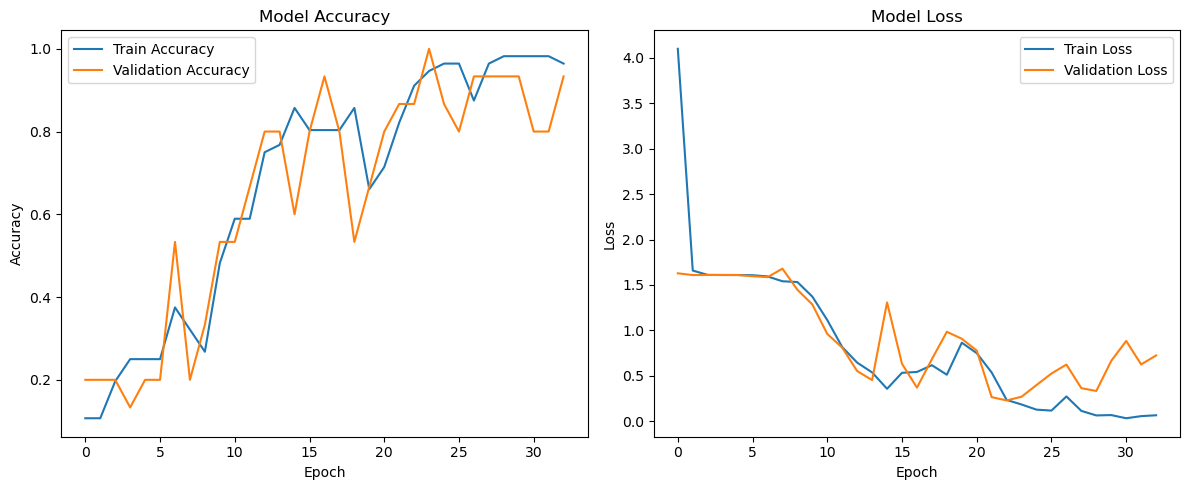

In [31]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model2 = load_model('yoga_pose_model2.h5')

# Define your pose names
pose_names = ['Padamasana', 'Tadasana', 'Vrikshasana', 'Trikasana', 'Bhujasana']

# Get predictions from the model
y_pred = model2.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_test, y_pred_classes)

# Display confusion matrix with actual pose names on axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pose_names)
disp.plot(cmap='Blues')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


NameError: name 'features_test' is not defined

In [34]:
from sklearn.metrics import classification_report

# Get the classification report with yoga pose names
report = classification_report(labels_test, y_pred_classes, target_names=pose_names)
print(report)


              precision    recall  f1-score   support

 Trikonasana       0.75      1.00      0.86         3
   Padmasana       0.75      1.00      0.86         3
 Vrikshasana       1.00      0.67      0.80         3
Bhujangasana       1.00      1.00      1.00         3
    Tadasana       1.00      0.67      0.80         3

    accuracy                           0.87        15
   macro avg       0.90      0.87      0.86        15
weighted avg       0.90      0.87      0.86        15



In [51]:
# Create the Streamlit app script
with open('app.py', 'w') as f:
    f.write("""
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
import cv2
import tempfile
import os

# Force UTF-8 encoding
import sys
sys.stdout.reconfigure(encoding='utf-8')

# Load your trained model
model = models.load_model('best_yoga_model.keras')

# Define the function to preprocess the input video
def preprocess_video(video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)  # Sample evenly from the video if it has more frames than needed
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)  # Set frame position
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128))  # Resize to the input size expected by the model
        frames.append(frame)
    
    cap.release()
    
    # If fewer than num_frames were read, duplicate the last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    frames = np.array(frames)
    frames = frames / 255.0  # Normalize pixel values
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    return frames

st.title("Yoga Pose Detection")
st.write("Upload a video to classify yoga poses.")

uploaded_file = st.file_uploader("Choose a video...", type=["mp4", "mov", "avi"])

if uploaded_file is not None:
    # Use tempfile to handle temporary video file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as temp_video_file:
        temp_video_file.write(uploaded_file.read())
        temp_video_path = temp_video_file.name
    
    # Preprocess the video
    video_data = preprocess_video(temp_video_path)
    
    # Make predictions
    predictions = model.predict(video_data)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Define class names for the yoga poses
    pose_names = ['Padamasana', 'Tadasana', 'Vrikshasana', 'Trikasana', 'Bhujasana']
    st.write(f"Predicted Pose: {pose_names[predicted_class]}")
    
    # Clean up the temporary video file
    os.remove(temp_video_path)

if __name__ == "__main__":
    st.write("Streamlit app is running...")

""")


In [52]:
!streamlit run app.py --server.enableXsrfProtection false



^C


In [50]:
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
import tempfile
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('best_yoga_model.keras')

# Function to preprocess video
def preprocess_video(video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)  # Evenly sample frames if more than 30

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)  # Capture frames at intervals
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128))  # Resize to 128x128
        frames.append(frame)

    cap.release()

    # Duplicate the last frame if there are fewer than num_frames frames
    while len(frames) < num_frames:
        frames.append(frames[-1])

    frames = np.array(frames)  # Shape: (num_frames, 128, 128, 3)
    frames = frames / 255.0  # Normalize pixel values to [0, 1]
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension: (1, num_frames, 128, 128, 3)
    return frames

# Streamlit app
st.title("Yoga Pose Detection")
st.write("Upload a video to classify yoga poses.")

uploaded_file = st.file_uploader("Choose a video...", type=["mp4", "mov", "avi"])

if uploaded_file is not None:
    # Create a temporary file to store the uploaded video
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(uploaded_file.read())
        video_data = preprocess_video(tmp_file.name, num_frames=30)  # Preprocess video

    # Make predictions using the best saved model
    predictions = model.predict(video_data)  # Predict yoga pose
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Class names for yoga poses
    pose_names = ['Padamasana', 'Tadasana', 'Vrikshasana', 'Trikasana', 'Bhujasana']

    st.write(f"Predicted Pose: {pose_names[predicted_class]}")
